In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline

In [25]:
data = pd.read_csv("covid_data.csv")

# Filter data untuk satu negara
# Cek negara yang tersedia terlebih dahulu
print("Beberapa negara yang tersedia:")
available_locations = data['location'].unique()
print(available_locations[:10])  # Tampilkan 10 negara pertama

# Pilih negara (default: Indonesia, bisa diganti)
location = "Indonesia"  # Ganti dengan negara yang diinginkan jika perlu

# Filter data
data_filtered = data[data['location'] == location].copy()

if len(data_filtered) == 0:
    print(f"\nPERINGATAN: Data untuk '{location}' tidak ditemukan!")
    print("Mencari negara alternatif...")
    # Cari negara yang punya data total_cases
    for loc in available_locations:
        temp_data = data[data['location'] == loc].copy()
        temp_data = temp_data[temp_data['total_cases'].notna()]
        temp_data = temp_data[temp_data['total_cases'] > 0]
        if len(temp_data) > 0:
            location = loc
            data_filtered = data[data['location'] == location].copy()
            print(f"Menggunakan data untuk: {location}")
            break
    else:
        raise ValueError("Tidak ada negara dengan data valid!")

# Hapus baris dengan total_cases NaN atau 0
data_filtered = data_filtered[data_filtered['total_cases'].notna()]
data_filtered = data_filtered[data_filtered['total_cases'] > 0]

if len(data_filtered) == 0:
    raise ValueError(f"Tidak ada data valid untuk {location}!")

# Urutkan berdasarkan tanggal
data_filtered = data_filtered.sort_values('date').reset_index(drop=True)

# Konversi date ke datetime dan buat kolom day (hari ke-n)
data_filtered['date'] = pd.to_datetime(data_filtered['date'])
data_filtered['day'] = (data_filtered['date'] - data_filtered['date'].min()).dt.days + 1

# Ambil kolom waktu dan jumlah kasus
time = data_filtered["day"].values
infected_data = data_filtered["total_cases"].values

print(f"\n✓ Data untuk: {location}")
print(f"✓ Jumlah data: {len(time)}")
print(f"✓ Total cases min: {infected_data.min():,.0f}, max: {infected_data.max():,.0f}")
print(f"✓ Hari pertama: {time[0]}, Hari terakhir: {time[-1]}")


Beberapa negara yang tersedia:
['Afghanistan' 'Africa' 'Albania' 'Algeria' 'Andorra' 'Angola' 'Anguilla'
 'Antigua and Barbuda' 'Argentina' 'Armenia']

✓ Data untuk: Indonesia
✓ Jumlah data: 734
✓ Total cases min: 2, max: 5,723,858
✓ Hari pertama: 1, Hari terakhir: 734


In [26]:
# Gunakan populasi aktual jika tersedia, atau estimasi dari max cases
if 'population' in data_filtered.columns and data_filtered['population'].notna().any():
    N = data_filtered['population'].iloc[0]
    print(f"✓ Menggunakan populasi aktual dari data")
else:
    # Estimasi populasi: asumsikan max cases adalah sekitar 5% dari populasi
    N = infected_data.max() * 20  # asumsi populasi lebih besar
    print(f"⚠ Menggunakan estimasi populasi (max_cases * 20)")

I_data = infected_data / N

print(f"\n✓ Populasi yang digunakan: {N:,.0f}")
print(f"✓ Proporsi terinfeksi min: {I_data.min():.6f}, max: {I_data.max():.6f}")
print(f"✓ Jumlah data I_data: {len(I_data)}")
if len(I_data) > 0:
    print(f"✓ Nilai pertama I_data: {I_data[0]:.6f}")
    print(f"✓ Nilai terakhir I_data: {I_data[-1]:.6f}")


✓ Menggunakan populasi aktual dari data

✓ Populasi yang digunakan: 276,361,788
✓ Proporsi terinfeksi min: 0.000000, max: 0.020711
✓ Jumlah data I_data: 734
✓ Nilai pertama I_data: 0.000000
✓ Nilai terakhir I_data: 0.020711


In [27]:
def model_sir(t, y, beta, gamma):
    S, I, R = y
    N = S + I + R

    dS_dt = -beta * S * I / N
    dI_dt = beta * S * I / N - gamma * I
    dR_dt = gamma * I

    return np.array([dS_dt, dI_dt, dR_dt])


In [28]:
def rk4_solver(f, t0, y0, h, n_steps, beta, gamma):
    t = t0
    y = y0

    t_values = [t]
    y_values = [y]

    for _ in range(n_steps):
        k1 = f(t, y, beta, gamma)
        k2 = f(t + h/2, y + h/2 * k1, beta, gamma)
        k3 = f(t + h/2, y + h/2 * k2, beta, gamma)
        k4 = f(t + h, y + h * k3, beta, gamma)

        y = y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + h

        t_values.append(t)
        y_values.append(y)

    return np.array(t_values), np.array(y_values)


In [29]:
S0 = 0.99
I0 = I_data[0]
R0 = 0.01

y0 = np.array([S0, I0, R0])

beta = 0.5    # tebakan awal
gamma = 0.1   # tebakan awal

h = 1
n_steps = len(time) - 1


In [30]:
t_sim, y_sim = rk4_solver(
    model_sir,
    t0=0,
    y0=y0,
    h=h,
    n_steps=n_steps,
    beta=beta,
    gamma=gamma
)

S_sim = y_sim[:, 0]
I_sim = y_sim[:, 1]
R_sim = y_sim[:, 2]


✓ Membuat grafik...
   Data asli: 734 titik, I_data range: 0.000000 - 0.020711
   Simulasi: 734 titik, I_sim range: 0.000000 - 0.469432


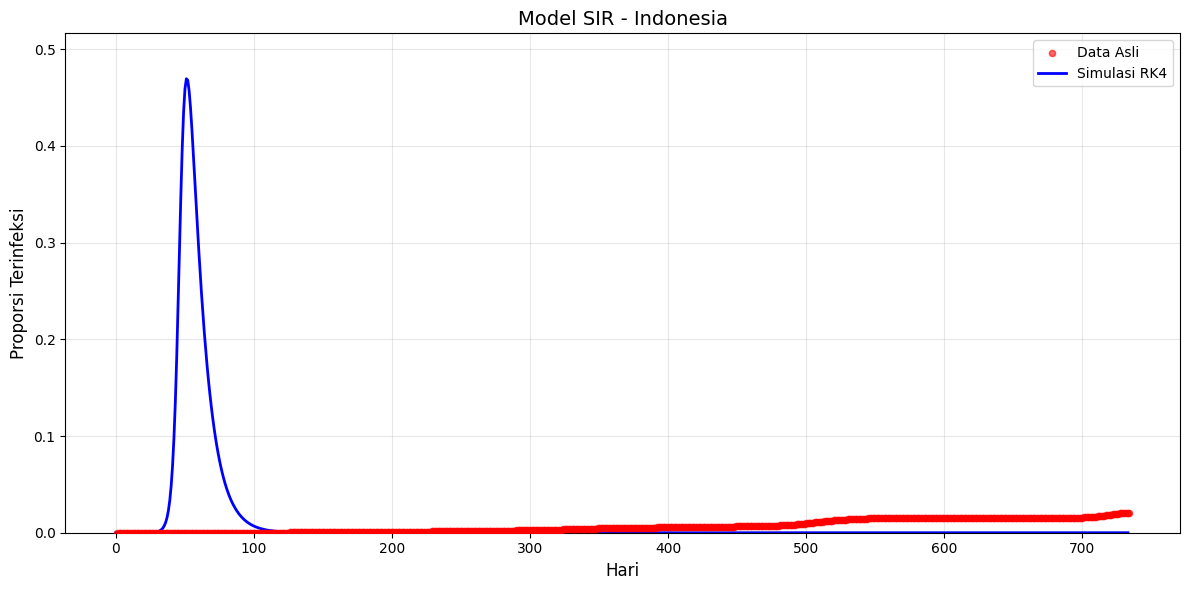


✓ Grafik berhasil dibuat!
   Data Asli - Hari 1: 0.000000, Hari 734: 0.020711
   Simulasi - Hari 0.0: 0.000000, Hari 733.0: 0.000000


In [31]:
# Cek apakah variabel location sudah didefinisikan
try:
    location_name = location
except NameError:
    location_name = "Data COVID-19"

# Pastikan semua variabel ada
if 'time' not in globals() or 'I_data' not in globals() or 't_sim' not in globals() or 'I_sim' not in globals():
    print("❌ ERROR: Variabel data belum didefinisikan!")
    print("   Pastikan semua cell dijalankan dari awal (cell 0 sampai 7)")
else:
    if len(time) == 0 or len(I_data) == 0:
        print("❌ ERROR: Data asli kosong!")
    elif len(t_sim) == 0 or len(I_sim) == 0:
        print("❌ ERROR: Data simulasi kosong!")
    else:
        print("✓ Membuat grafik...")
        print(f"   Data asli: {len(time)} titik, I_data range: {I_data.min():.6f} - {I_data.max():.6f}")
        print(f"   Simulasi: {len(t_sim)} titik, I_sim range: {I_sim.min():.6f} - {I_sim.max():.6f}")
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Plot data
        ax.scatter(time, I_data, label="Data Asli", color="red", s=20, alpha=0.6, zorder=3)
        ax.plot(t_sim, I_sim, label="Simulasi RK4", color="blue", linewidth=2, zorder=2)
        
        # Labels
        ax.set_xlabel("Hari", fontsize=12)
        ax.set_ylabel("Proporsi Terinfeksi", fontsize=12)
        ax.set_title(f"Model SIR - {location_name}", fontsize=14)
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.3)
        
        # Set axis limits dengan margin
        x_min = min(time.min(), t_sim.min())
        x_max = max(time.max(), t_sim.max())
        y_min = min(I_data.min(), I_sim.min())
        y_max = max(I_data.max(), I_sim.max())
        
        x_margin = (x_max - x_min) * 0.05
        y_margin = (y_max - y_min) * 0.1 if y_max > y_min else 0.01
        
        ax.set_xlim(x_min - x_margin, x_max + x_margin)
        ax.set_ylim(max(0, y_min - y_margin), y_max + y_margin)
        
        plt.tight_layout()
        plt.show()
        
        print(f"\n✓ Grafik berhasil dibuat!")
        print(f"   Data Asli - Hari {time[0]}: {I_data[0]:.6f}, Hari {time[-1]}: {I_data[-1]:.6f}")
        print(f"   Simulasi - Hari {t_sim[0]:.1f}: {I_sim[0]:.6f}, Hari {t_sim[-1]:.1f}: {I_sim[-1]:.6f}")


In [32]:
# Hitung RMSE antara data asli dan simulasi
rmse = np.sqrt(np.mean((I_data - I_sim)**2))
print(f"RMSE = {rmse:.6f}")
print(f"RMSE dalam persen: {rmse*100:.2f}%")


RMSE = 0.063889
RMSE dalam persen: 6.39%


In [33]:
# METODE 1: Parameter Tuning Manual (Trial & Error)
# Coba berbagai kombinasi beta dan gamma, lalu pilih yang menghasilkan RMSE terkecil

def calculate_rmse(beta, gamma):
    """Hitung RMSE untuk kombinasi parameter tertentu"""
    # Jalankan simulasi dengan parameter baru
    t_sim_temp, y_sim_temp = rk4_solver(
        model_sir,
        t0=0,
        y0=y0,
        h=h,
        n_steps=n_steps,
        beta=beta,
        gamma=gamma
    )
    I_sim_temp = y_sim_temp[:, 1]
    
    # Hitung RMSE
    rmse_temp = np.sqrt(np.mean((I_data - I_sim_temp)**2))
    return rmse_temp, I_sim_temp

# Grid Search sederhana - coba berbagai nilai
print("=== PARAMETER TUNING MANUAL ===")
print("Mencari kombinasi beta dan gamma terbaik...\n")

beta_range = np.linspace(0.1, 1.0, 10)  # 10 nilai dari 0.1 sampai 1.0
gamma_range = np.linspace(0.05, 0.3, 10)  # 10 nilai dari 0.05 sampai 0.3

best_rmse = float('inf')
best_beta = None
best_gamma = None
best_I_sim = None

results = []

for beta in beta_range:
    for gamma in gamma_range:
        rmse_temp, I_sim_temp = calculate_rmse(beta, gamma)
        results.append({
            'beta': beta,
            'gamma': gamma,
            'rmse': rmse_temp
        })
        
        if rmse_temp < best_rmse:
            best_rmse = rmse_temp
            best_beta = beta
            best_gamma = gamma
            best_I_sim = I_sim_temp

print(f"✓ Parameter terbaik ditemukan:")
print(f"   Beta (laju penularan): {best_beta:.4f}")
print(f"   Gamma (laju recovery): {best_gamma:.4f}")
print(f"   RMSE: {best_rmse:.6f}")
print(f"   RMSE sebelumnya: {rmse:.6f}")
print(f"   Perbaikan: {((rmse - best_rmse) / rmse * 100):.2f}%")

# Update parameter terbaik
beta = best_beta
gamma = best_gamma
I_sim = best_I_sim
t_sim = np.arange(len(I_sim))


=== PARAMETER TUNING MANUAL ===
Mencari kombinasi beta dan gamma terbaik...

✓ Parameter terbaik ditemukan:
   Beta (laju penularan): 0.1000
   Gamma (laju recovery): 0.0778
   RMSE: 0.006673
   RMSE sebelumnya: 0.063889
   Perbaikan: 89.55%


In [34]:
# METODE 2: Parameter Tuning Otomatis dengan scipy.optimize (Nilai Plus)
# Metode ini lebih efisien dan akurat dibanding trial & error manual

from scipy.optimize import minimize

def objective_function(params):
    """Fungsi objektif untuk optimasi - meminimalkan RMSE"""
    beta_opt, gamma_opt = params
    
    # Batasi nilai parameter agar masuk akal
    if beta_opt < 0 or gamma_opt < 0 or beta_opt > 2 or gamma_opt > 1:
        return 1e10  # Return nilai besar jika parameter tidak valid
    
    # Jalankan simulasi
    t_sim_opt, y_sim_opt = rk4_solver(
        model_sir,
        t0=0,
        y0=y0,
        h=h,
        n_steps=n_steps,
        beta=beta_opt,
        gamma=gamma_opt
    )
    I_sim_opt = y_sim_opt[:, 1]
    
    # Hitung RMSE
    rmse_opt = np.sqrt(np.mean((I_data - I_sim_opt)**2))
    return rmse_opt

print("=== PARAMETER TUNING OTOMATIS (scipy.optimize) ===")
print("Mengoptimalkan parameter dengan algoritma Nelder-Mead...\n")

# Nilai awal (dari grid search sebelumnya atau tebakan)
initial_params = [best_beta, best_gamma]

# Optimasi
result = minimize(
    objective_function,
    initial_params,
    method='Nelder-Mead',
    options={'maxiter': 100, 'xatol': 1e-6}
)

beta_optimal = result.x[0]
gamma_optimal = result.x[1]
rmse_optimal = result.fun

print(f"✓ Parameter optimal ditemukan:")
print(f"   Beta (laju penularan): {beta_optimal:.6f}")
print(f"   Gamma (laju recovery): {gamma_optimal:.6f}")
print(f"   RMSE optimal: {rmse_optimal:.6f}")
print(f"   Iterasi: {result.nit}")
print(f"   Status: {result.message}")

# Simulasi dengan parameter optimal
t_sim_optimal, y_sim_optimal = rk4_solver(
    model_sir,
    t0=0,
    y0=y0,
    h=h,
    n_steps=n_steps,
    beta=beta_optimal,
    gamma=gamma_optimal
)
I_sim_optimal = y_sim_optimal[:, 1]

# Update ke parameter optimal
beta = beta_optimal
gamma = gamma_optimal
I_sim = I_sim_optimal
t_sim = np.arange(len(I_sim))
rmse = rmse_optimal


=== PARAMETER TUNING OTOMATIS (scipy.optimize) ===
Mengoptimalkan parameter dengan algoritma Nelder-Mead...

✓ Parameter optimal ditemukan:
   Beta (laju penularan): 0.132832
   Gamma (laju recovery): 0.105370
   RMSE optimal: 0.004301
   Iterasi: 50
   Status: Optimization terminated successfully.


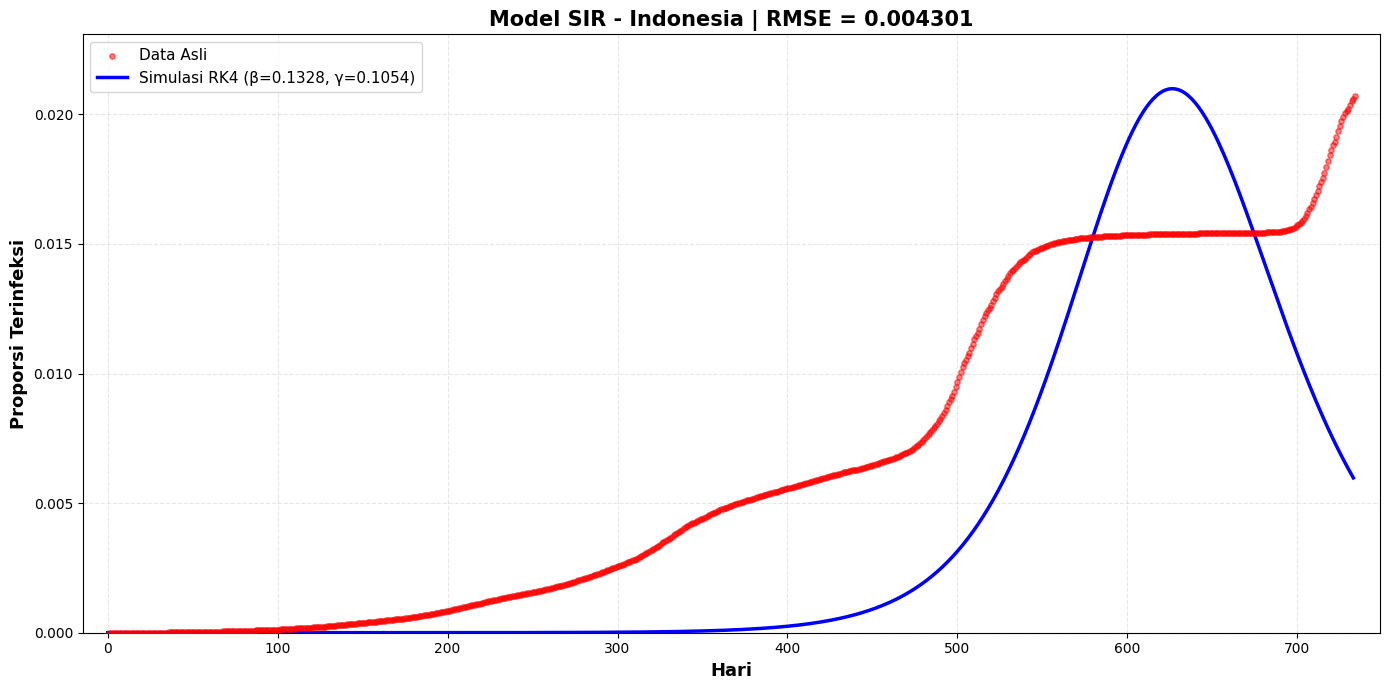


✓ Grafik perbandingan berhasil dibuat!
   Parameter: β = 0.132832, γ = 0.105370
   RMSE: 0.004301 (0.43%)


In [35]:
# Visualisasi Perbandingan: Data Asli vs Simulasi dengan Parameter Optimal
try:
    location_name = location
except NameError:
    location_name = "Data COVID-19"

fig, ax = plt.subplots(figsize=(14, 7))

# Plot data asli (scatter)
ax.scatter(time, I_data, label="Data Asli", color="red", s=15, alpha=0.5, zorder=3)

# Plot simulasi dengan parameter optimal (line)
ax.plot(t_sim, I_sim, label=f"Simulasi RK4 (β={beta:.4f}, γ={gamma:.4f})", 
        color="blue", linewidth=2.5, zorder=2)

# Labels dan styling
ax.set_xlabel("Hari", fontsize=13, fontweight='bold')
ax.set_ylabel("Proporsi Terinfeksi", fontsize=13, fontweight='bold')
ax.set_title(f"Model SIR - {location_name} | RMSE = {rmse:.6f}", fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3, linestyle='--')

# Set axis limits
x_min = min(time.min(), t_sim.min())
x_max = max(time.max(), t_sim.max())
y_min = min(I_data.min(), I_sim.min())
y_max = max(I_data.max(), I_sim.max())

x_margin = (x_max - x_min) * 0.02
y_margin = (y_max - y_min) * 0.1 if y_max > y_min else 0.01

ax.set_xlim(x_min - x_margin, x_max + x_margin)
ax.set_ylim(max(0, y_min - y_margin), y_max + y_margin)

plt.tight_layout()
plt.show()

print(f"\n✓ Grafik perbandingan berhasil dibuat!")
print(f"   Parameter: β = {beta:.6f}, γ = {gamma:.6f}")
print(f"   RMSE: {rmse:.6f} ({rmse*100:.2f}%)")


In [36]:
# INTERPRETASI PARAMETER MODEL SIR

print("=" * 60)
print("INTERPRETASI PARAMETER MODEL SIR")
print("=" * 60)

# Hitung R0 (Reproduction Number)
R0 = beta / gamma
print(f"\n1. PARAMETER BETA (β) = {beta:.6f}")
print(f"   → Laju penularan (transmission rate)")
print(f"   → Artinya: Setiap hari, setiap orang terinfeksi dapat menularkan")
print(f"     penyakit ke {beta:.2f} orang lain (dalam kondisi populasi rentan penuh)")
print(f"   → Semakin besar β, semakin cepat penyebaran penyakit")

print(f"\n2. PARAMETER GAMMA (γ) = {gamma:.6f}")
print(f"   → Laju recovery (recovery rate)")
print(f"   → Artinya: Setiap hari, {gamma*100:.2f}% dari populasi terinfeksi")
print(f"     akan sembuh atau diisolasi")
print(f"   → Waktu rata-rata recovery: {1/gamma:.2f} hari")
print(f"   → Semakin besar γ, semakin cepat pasien sembuh")

print(f"\n3. REPRODUCTION NUMBER (R₀) = β/γ = {R0:.4f}")
if R0 > 1:
    print(f"   → R₀ > 1: Penyakit akan menyebar (epidemi)")
    print(f"   → Setiap 1 orang terinfeksi akan menularkan ke {R0:.2f} orang lain")
elif R0 < 1:
    print(f"   → R₀ < 1: Penyakit akan menurun (tidak menjadi epidemi)")
    print(f"   → Setiap 1 orang terinfeksi akan menularkan ke kurang dari 1 orang")
else:
    print(f"   → R₀ = 1: Penyakit berada pada titik kritis")

print(f"\n4. ANALISIS DATA:")
print(f"   → Total hari pengamatan: {len(time)} hari ({len(time)/30:.1f} bulan)")
print(f"   → Proporsi maksimum terinfeksi: {I_data.max()*100:.2f}%")
print(f"   → Proporsi akhir terinfeksi: {I_data[-1]*100:.2f}%")
print(f"   → Jumlah maksimum kasus: {infected_data.max():,.0f} orang")
print(f"   → Jumlah akhir kasus: {infected_data[-1]:,.0f} orang")

print(f"\n5. KUALITAS MODEL:")
print(f"   → RMSE: {rmse:.6f} ({rmse*100:.2f}%)")
if rmse < 0.01:
    print(f"   → Model sangat akurat (RMSE < 1%)")
elif rmse < 0.05:
    print(f"   → Model akurat (RMSE < 5%)")
elif rmse < 0.1:
    print(f"   → Model cukup akurat (RMSE < 10%)")
else:
    print(f"   → Model perlu perbaikan (RMSE > 10%)")

print("\n" + "=" * 60)


INTERPRETASI PARAMETER MODEL SIR

1. PARAMETER BETA (β) = 0.132832
   → Laju penularan (transmission rate)
   → Artinya: Setiap hari, setiap orang terinfeksi dapat menularkan
     penyakit ke 0.13 orang lain (dalam kondisi populasi rentan penuh)
   → Semakin besar β, semakin cepat penyebaran penyakit

2. PARAMETER GAMMA (γ) = 0.105370
   → Laju recovery (recovery rate)
   → Artinya: Setiap hari, 10.54% dari populasi terinfeksi
     akan sembuh atau diisolasi
   → Waktu rata-rata recovery: 9.49 hari
   → Semakin besar γ, semakin cepat pasien sembuh

3. REPRODUCTION NUMBER (R₀) = β/γ = 1.2606
   → R₀ > 1: Penyakit akan menyebar (epidemi)
   → Setiap 1 orang terinfeksi akan menularkan ke 1.26 orang lain

4. ANALISIS DATA:
   → Total hari pengamatan: 734 hari (24.5 bulan)
   → Proporsi maksimum terinfeksi: 2.07%
   → Proporsi akhir terinfeksi: 2.07%
   → Jumlah maksimum kasus: 5,723,858 orang
   → Jumlah akhir kasus: 5,723,858 orang

5. KUALITAS MODEL:
   → RMSE: 0.004301 (0.43%)
   → Mode